In [1]:
from tqdm import tqdm
import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
# data_flag = 'pathmnist'
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 50
BATCH_SIZE = 32
learning_rate = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/caesar/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/caesar/.medmnist/breastmnist.npz


In [5]:
(x_train, y_train) = (train_dataset.imgs, train_dataset.labels)
(x_test, y_test) = (test_dataset.imgs, test_dataset.labels)

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /home/caesar/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 156
    Root location: /home/caesar/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'm

In [7]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [8]:
x_train.shape, x_test.shape

((546, 28, 28), (156, 28, 28))

In [9]:
x_train = x_train.reshape((len(x_train), 28, 28, 1))
x_test = x_test.reshape((len(x_test), 28, 28, 1))

In [10]:
x_train.shape, x_test.shape

((546, 28, 28, 1), (156, 28, 28, 1))

In [11]:
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

2024-01-20 17:25:48.264950: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-20 17:25:48.290432: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-20 17:25:48.290455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-20 17:25:48.291080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-20 17:25:48.295405: I tensorflow/core/platform/cpu_feature_guar

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
tf.__version__
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten


autoencoder = Sequential()

# Encoder
autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=(28,28,1)))
autoencoder.add(MaxPooling2D(pool_size=(2,2)))

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#autoencoder.summary()

autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding = 'same', strides=(2,2)))

autoencoder.add(Flatten())

#autoencoder.summary()

# Decoder

autoencoder.add(Reshape((4,4,8)))
#autoencoder.summary()
autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
#autoencoder.summary()
autoencoder.add(UpSampling2D(size=(2,2)))
#autoencoder.summary()

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D(size=(2,2)))

autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu'))
autoencoder.add(UpSampling2D(size=(2,2)))

autoencoder.add(Conv2D(filters = 1, kernel_size=(3,3), activation='sigmoid', padding='same'))
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0

In [13]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [14]:
autoencoder.fit(x_train, x_train, epochs = 50)

Epoch 1/50
 1/18 [>.............................] - ETA: 13s - loss: 0.6963 - accuracy: 7.9719e-05

2024-01-20 17:25:50.238733: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8f6c01d6d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-01-20 17:25:50.238768: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-01-20 17:25:50.254216: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705789550.381959 4170385 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-01-20 17:25:50.382889: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-01-20 17:25:50.395331: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-01-20 17:25:50.414740: E external/local_xla/xl

18/18 [==============================] - 1s 9ms/step - loss: 0.6743 - accuracy: 1.7054e-04
Epoch 2/50
18/18 [==============================] - 0s 8ms/step - loss: 0.6262 - accuracy: 1.7287e-04
Epoch 3/50
 1/18 [>.............................] - ETA: 0s - loss: 0.5939 - accuracy: 0.0000e+00

2024-01-20 17:25:50.505743: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


18/18 [==============================] - 0s 8ms/step - loss: 0.5901 - accuracy: 1.0279e-04
Epoch 4/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5731 - accuracy: 1.7287e-04
Epoch 5/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5623 - accuracy: 1.7287e-04
Epoch 6/50
18/18 [==============================] - 0s 7ms/step - loss: 0.5571 - accuracy: 1.7521e-04
Epoch 7/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5538 - accuracy: 1.7988e-04
Epoch 8/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5518 - accuracy: 1.7754e-04
Epoch 9/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5504 - accuracy: 1.7754e-04
Epoch 10/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5491 - accuracy: 1.7988e-04
Epoch 11/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5480 - accuracy: 1.7988e-04
Epoch 12/50
18/18 [==============================] - 0s 7ms/step - loss: 0.5473 - accuracy:

2024-01-20 17:25:54.201085: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


18/18 [==============================] - 0s 8ms/step - loss: 0.5431 - accuracy: 1.7988e-04
Epoch 30/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5427 - accuracy: 1.7988e-04
Epoch 31/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5425 - accuracy: 1.7988e-04
Epoch 32/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5424 - accuracy: 1.7988e-04
Epoch 33/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5421 - accuracy: 1.7988e-04
Epoch 34/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5419 - accuracy: 1.7988e-04
Epoch 35/50
18/18 [==============================] - 0s 7ms/step - loss: 0.5421 - accuracy: 1.7988e-04
Epoch 36/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5416 - accuracy: 1.7988e-04
Epoch 37/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5415 - accuracy: 1.7988e-04
Epoch 38/50
18/18 [==============================] - 0s 8ms/step - loss: 0.5413 - acc

In [15]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 flatten (Flatten)           (None, 128)               0

In [16]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('flatten').output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 8)           584   

In [17]:
# coded_test_images = encoder.predict(x_test)
coded_test_images = encoder.predict(x_train)

18/18 [==============================] - 0s 4ms/step


In [18]:
coded_test_images.shape

(546, 128)

In [19]:
coded_test_images[0]

array([0.        , 0.2151155 , 0.19510825, 0.30057782, 0.        ,
       0.5270001 , 0.19569816, 0.24577862, 0.08658922, 0.        ,
       0.18878815, 0.43651944, 0.        , 0.7425665 , 0.30911177,
       0.37667823, 0.12130246, 0.        , 0.15027152, 0.42913342,
       0.        , 0.70586854, 0.24654809, 0.28053018, 0.10982571,
       0.        , 0.10769991, 0.41642165, 0.        , 0.4727967 ,
       0.2523265 , 0.23833916, 0.        , 0.4414532 , 0.2800281 ,
       0.68196535, 0.07804294, 0.77029485, 0.14323992, 0.62010354,
       0.21632655, 0.        , 0.21583363, 0.8842144 , 0.        ,
       1.1102147 , 0.25177273, 0.63237846, 0.24743623, 0.        ,
       0.12150836, 0.7994484 , 0.        , 1.0673068 , 0.20117502,
       0.59450203, 0.31272557, 0.        , 0.14338017, 0.5848014 ,
       0.        , 0.73671275, 0.2877711 , 0.25474283, 0.        ,
       0.37351185, 0.25918934, 0.5268551 , 0.31607488, 0.7463697 ,
       0.15896727, 0.6028958 , 0.23906597, 0.04451183, 0.30234

In [20]:
decoded_test_images = autoencoder.predict(x_test)
decoded_test_images.shape

5/5 [==============================] - 0s 8ms/step


(156, 28, 28, 1)

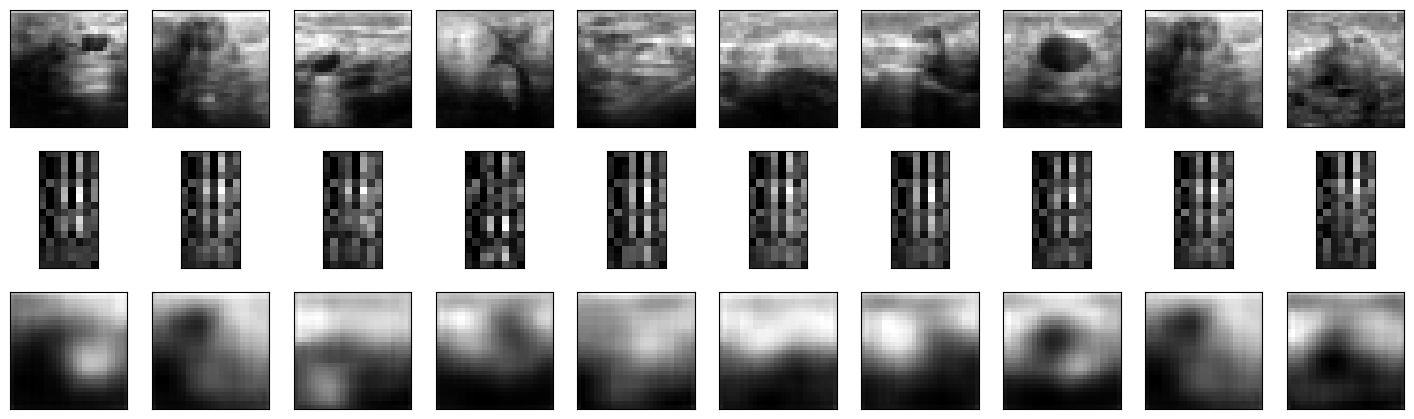

In [21]:
n_images = 10
test_images = np.random.randint(0, x_test.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # Original images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(x_test[image_index].reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Coded images
  ax = plt.subplot(10,10, i + 1 + n_images)
  plt.imshow(coded_test_images[image_index].reshape(16,8), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded images
  ax = plt.subplot(10,10, i + 1 + n_images * 2)
  plt.imshow(decoded_test_images[image_index].reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

In [22]:
X_train = encoder.predict(x_train)
X_test = encoder.predict(x_test)

5/5 [==============================] - 0s 4ms/step


In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(546, 128)
(156, 128)
(546, 1)
(156, 1)


In [24]:
# data scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

In [25]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [26]:
# Run a binary SVC classifier
# Create and fit the model

# Define the parameter ranges
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': ['scale', 'auto',100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']} 

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3)

grid.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.727 total time=   0.0s
[CV 2/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.734 total time=   0.0s
[CV 3/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.734 total time=   0.0s
[CV 4/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.734 total time=   0.0s
[CV 5/5] END ....C=0.1, gamma=scale, kernel=rbf;, score=0.725 total time=   0.0s
[CV 1/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.727 total time=   0.0s
[CV 2/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.734 total time=   0.0s
[CV 3/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.734 total time=   0.0s
[CV 4/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.734 total time=   0.0s
[CV 5/5] END .C=0.1, gamma=scale, kernel=linear;, score=0.725 total time=   0.0s
[CV 1/5] END ...C=0.1, gamma=scale, kernel=poly;, score=0.745 total time=   0.0s
[CV 2/5] END ...C=0.1, gamma=scale, kernel=pol

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': ['scale', 'auto', 100, 10, 1, 0.1, 0.01,
                                   0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             verbose=3)

In [27]:
# Print the best parameters
print(grid.best_params_)

# Predict the test set results
grid_predictions = grid.predict(X_test)

{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}


In [28]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, grid_predictions)

print(f"Accuracy: {accuracy * 100}%")


Accuracy: 82.6923076923077%


              precision    recall  f1-score   support

           0       0.71      0.60      0.65        42
           1       0.86      0.91      0.89       114

    accuracy                           0.83       156
   macro avg       0.79      0.75      0.77       156
weighted avg       0.82      0.83      0.82       156



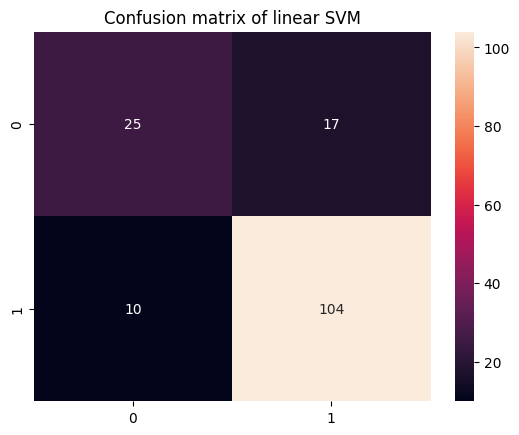

In [29]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion matrix of linear SVM') # fmt='d' formats the numbers as digits, which means integers

print(classification_report(y_test,grid_predictions))